<a href="https://colab.research.google.com/github/DrAlexSanz/NLP-SPEC-C4/blob/main/W2/Assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 2: Transformer Summarizer¶
Welcome to the second assignment of course 4. In this assignment you will explore summarization using the transformer model. Yes, you will implement the transformer decoder from scratch, but we will slowly walk you through it. There are many hints in this notebook so feel free to use them as needed.

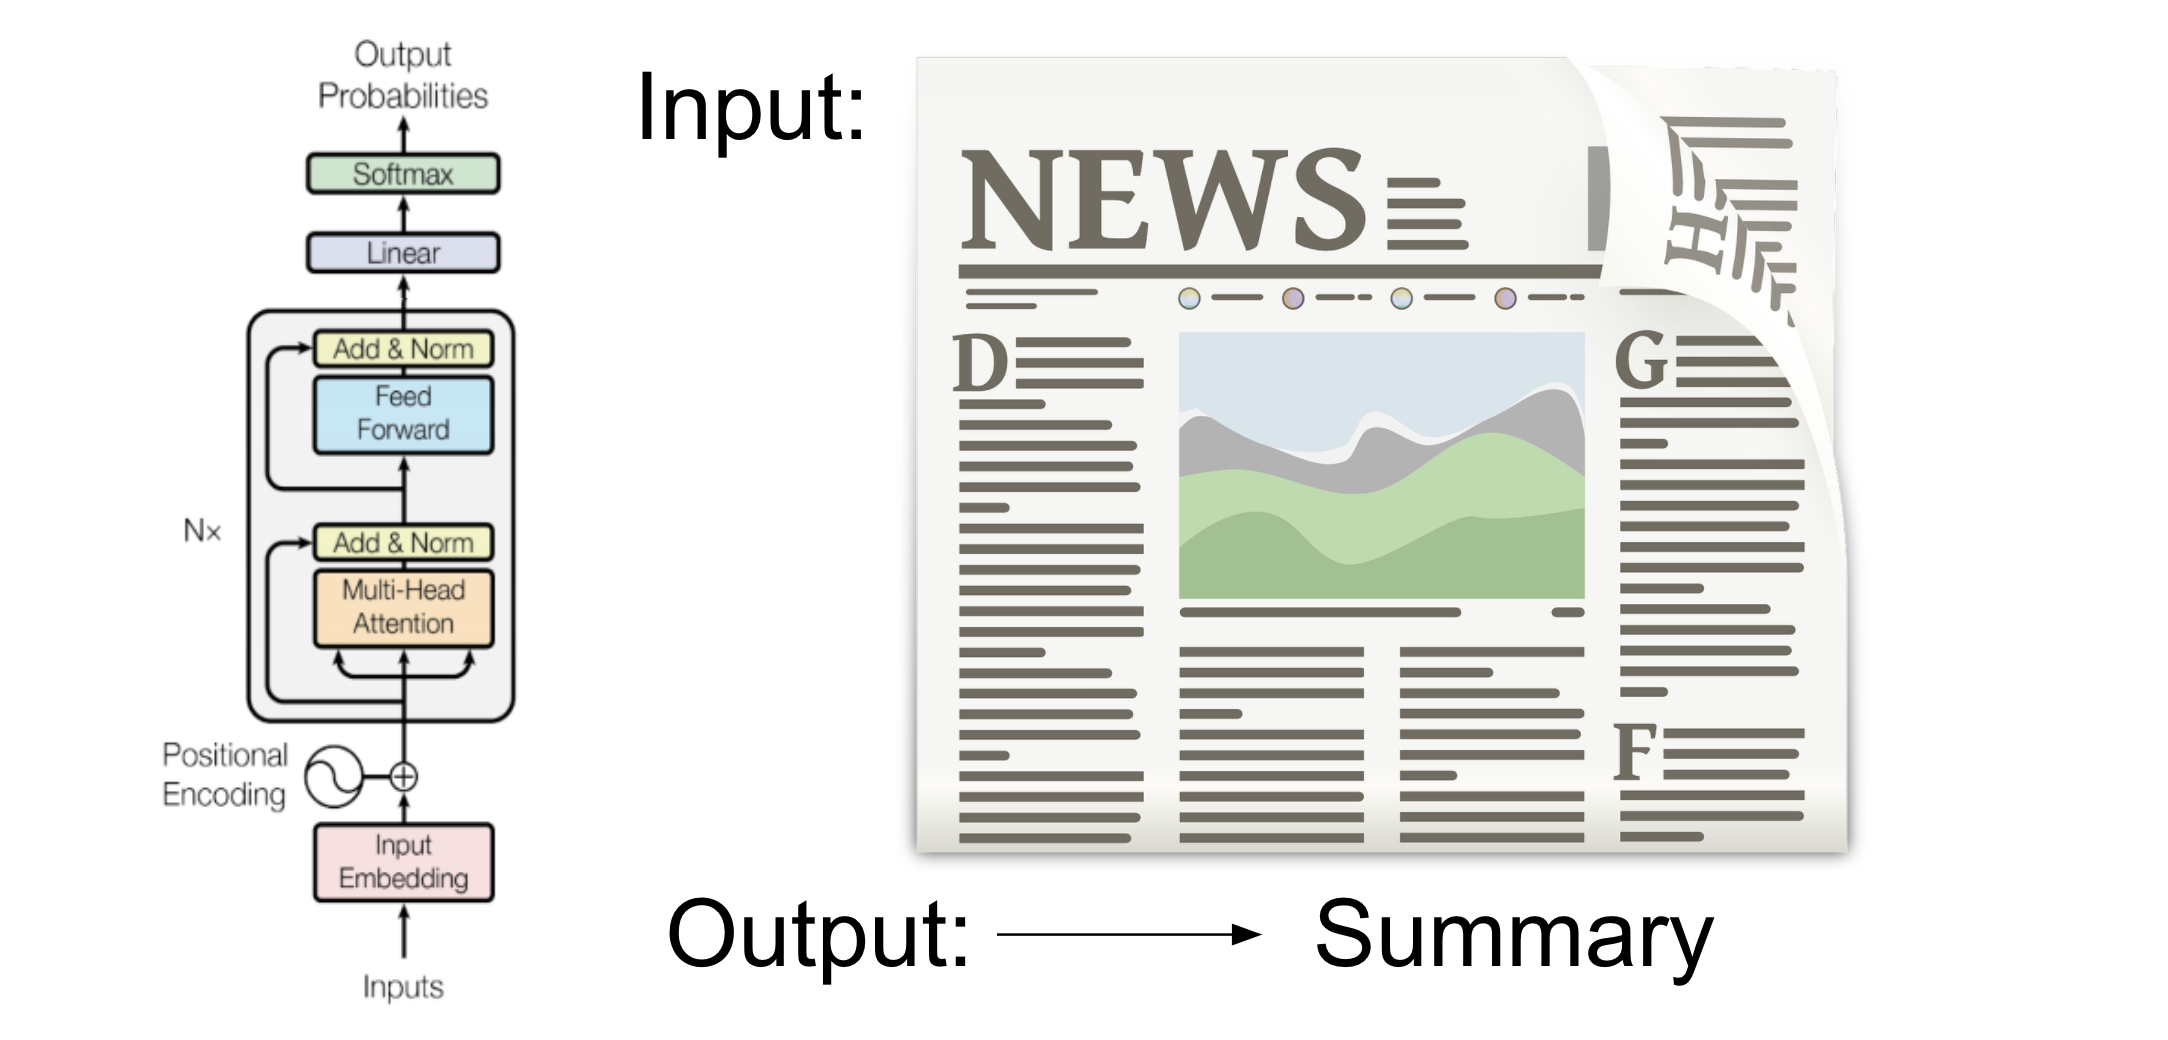

#Introduction
Summarization is an important task in natural language processing and could be useful for a consumer enterprise. For example, bots can be used to scrape articles, summarize them, and then you can use sentiment analysis to identify the sentiment about certain stocks. Anyways who wants to read an article or a long email today, when you can build a transformer to summarize text for you. Let's get started, by completing this assignment you will learn to:

* Use built-in functions to preprocess your data
* Implement DotProductAttention
* Implement Causal Attention
* Understand how attention works
* Build the transformer model
* Evaluate your model
* Summarize an article

As you can tell, this model is slightly different than the ones you have already implemented. This is heavily based on attention and does not rely on sequences, which allows for parallel computing.

In [1]:
!pip install trax

import sys
import os

import numpy as np

import textwrap
wrapper = textwrap.TextWrapper(width=70)

import trax
from trax import layers as tl
from trax.fastmath import numpy as jnp
from trax.supervised import training

# to print the entire np array
np.set_printoptions(threshold=sys.maxsize)

     |████████████████████████████████| 522kB 16.4MB/s 
     |████████████████████████████████| 215kB 50.3MB/s 
     |████████████████████████████████| 3.4MB 55.1MB/s 
     |████████████████████████████████| 1.2MB 53.2MB/s 
     |████████████████████████████████| 368kB 54.5MB/s 
     |████████████████████████████████| 71kB 12.0MB/s 
     |████████████████████████████████| 1.8MB 53.6MB/s 
     |████████████████████████████████| 3.8MB 49.4MB/s 
     |████████████████████████████████| 2.9MB 40.1MB/s 
     |████████████████████████████████| 890kB 54.8MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=fa144d9acd11b2217631bc960e0e1bbfffd582a5a7beb336a42fe31ccd3775af
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


#Part 1: Importing the dataset
Trax makes it easy to work with Tensorflow's datasets:

In [2]:
# This will download the dataset if no data_dir is specified.
# Downloading and processing can take bit of time,
# so we have the data already in 'data/' for you

# Importing CNN/DailyMail articles dataset
train_stream_fn = trax.data.TFDS('cnn_dailymail',
                                 data_dir='data/',
                                 keys=('article', 'highlights'),
                                 train=True)

# This should be much faster as the data is downloaded already.
eval_stream_fn = trax.data.TFDS('cnn_dailymail',
                                data_dir='data/',
                                keys=('article', 'highlights'),
                                train=False)

Dataset cnn_dailymail downloaded and prepared to data/cnn_dailymail/3.1.0. Subsequent calls will reuse this data.


In [3]:
!rm -rf "NLP-SPEC-C4"
!git clone https://github.com/DrAlexSanz/NLP-SPEC-C4.git
!mkdir "vocab_dir"
!cp "NLP-SPEC-C4/W2/vocab_dir/summarize32k.subword.subwords" "vocab_dir"
!rm -rf "NLP-SPEC-C4"

Cloning into 'NLP-SPEC-C4'...
remote: Enumerating objects: 87, done.
remote: Counting objects: 100% (87/87), done.
remote: Compressing objects: 100% (70/70), done.
remote: Total 87 (delta 22), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (87/87), done.


## 1.1 Tokenize & Detokenize helper functions
Just like in the previous assignment, the cell above loads in the encoder for you. Given any data set, you have to be able to map words to their indices, and indices to their words. The inputs and outputs to your Trax models are usually tensors of numbers where each number corresponds to a word. If you were to process your data manually, you would have to make use of the following:

* word2Ind: a dictionary mapping the word to its index.
* ind2Word: a dictionary mapping the index to its word.
* word2Count: a dictionary mapping the word to the number of times it appears.
* num_words: total number of words that have appeared.

Since you have already implemented these in previous assignments of the specialization, we will provide you with helper functions that will do this for you. Run the cell below to get the following functions:

* tokenize: converts a text sentence to its corresponding token list (i.e. list of indices). Also converts words to subwords.
* detokenize: converts a token list to its corresponding sentence (i.e. string).

In [4]:
def tokenize(input_string, EOS = 1):
    """
    # Use the trax.data.tokenize method. It takes streams and returns streams,
    # we get around it by making a 1-element stream with `iter`.   
    """

    inputs = next(trax.data.tokenize(iter([input_string]),
                                     vocab_dir = "vocab_dir/",
                                     vocab_file = "summarize32k.subword.subwords"))
    
    return list(inputs) + [EOS]

In [5]:
def detokenize(integers):

    s = trax.data.detokenize(integers,
                             vocab_dir = "vocab_dir",
                             vocab_file = "summarize32k.subword.subwords")
    
    return wrapper.fill(s)

## 1.2 Preprocessing for Language Models: Concatenate It!
This week you will use a language model -- Transformer Decoder -- to solve an input-output problem. As you know, language models only predict the next word, they have no notion of inputs. To create a single input suitable for a language model, we concatenate inputs with targets putting a separator in between. We also need to create a mask -- with 0s at inputs and 1s at targets -- so that the model is not penalized for mis-predicting the article and only focuses on the summary. See the preprocess function below for how this is done.

In [6]:
SEP = 0
EOS = 1

In [7]:
def preprocess(stream):
    for (article, summary) in stream:
        joint = np.array(list(article) + [SEP] + [EOS] + list(summary) + [EOS]) # This is a concat

        mask = [0] * (len(list(article)) + 2) + [1] * (len(list(summary)) + 1)

        yield joint, joint, np.array(mask)

In [8]:
# combine a few data preprocessing steps into a pipeline

input_pipeline = trax.data.Serial(
                                  trax.data.Tokenize(vocab_dir = "vocab_dir/",
                                                     vocab_file = "summarize32k.subword.subwords"),
                                  preprocess,
                                  trax.data.FilterByLength(2048)
                                  )

train_stream = input_pipeline(train_stream_fn())
eval_stream = input_pipeline(eval_stream_fn())

train_input, train_target, train_mask = next(train_stream)

assert sum((train_input - train_target) ** 2) == 0

In [9]:
# prints mask, 0s on article, 1s on summary
print(f'Single example mask:\n\n {train_mask}')

Single example mask:

 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1

In [10]:
# prints: [Example][<EOS>][<pad>][Example Summary][<EOS>]
print(f'Single example:\n\n {detokenize(train_input)}')

Single example:

 Standoff: Goerge Pickering, pictured, allegedly threatened to kill a
nurse . A distraught father who caused a four-hour standoff with
police in a Texas hospital allegedly pointed his gun at a nurse and
yelled 'I'll kill all of y'all'. Police said George Pickering, 57,
made the threats from a hospital room after becoming inconsolable over
the treatment of his son - a patient in critical care at Tomball
Regional Hospital, near Houston. Armed police and a SWAT team
descended on the medical center - and eventually convinced Pickering
to surrender after a four-hour standoff on Saturday night. Pickering
was charged with aggravated assault with a deadly weapon and is being
held on a $30,000 bond, a statement from the Tomball Police department
said. Detectives said Pickering was in the room with his son and
family, waited for a nurse to come, then aimed his 9mm pistol at her.
He then allegedly barricaded the room and threatened to kill anybody
who came in. At the start of the

## 1.3 Batching with bucketing
As in the previous week, we use bucketing to create batches of data.

In [11]:
# Bucketing to create batched generators.

# Buckets are defined in terms of boundaries and batch sizes.
# Batch_sizes[i] determines the batch size for items with length < boundaries[i]
# So below, we'll take a batch of 16 sentences of length < 128 , 8 of length < 256,
# 4 of length < 512. And so on. 

boundaries = [128, 256, 512, 1024, 2048]
batch_sizes = [16, 8, 4, 2, 1]

train_batch_stream = trax.data.BucketByLength(boundaries, batch_sizes)(train_stream)
eval_batch_stream = trax.data.BucketByLength(boundaries, batch_sizes)(eval_stream)


In [12]:
# Every execution will result in generation of a different article
# Try running this cell multiple times to see how the length of the examples affects the batch size
input_batch, _, mask_batch = next(train_batch_stream)

# Shape of the input_batch
input_batch.shape

(2, 1024)

In [13]:
print(input_batch[0])

[11945     7     5   263   357   372   108    18   375   320 15201  1248
   213 22549   117 12385  8070  5956    80   384     2    35  5904 13559
  7189  5435    41  5290     7    26   188   412   227   412   213 11945
   384  1838   137    91  1008     3 12547  8006  4402  7227     7     5
   384  1435   950   290   694   869   809   213   448   527   213  6268
   951     2    35   102 17518  2769 16167   214   148  3389   324   186
   257     2    31 14077 17638     4    23    46   316    71   883  1782
   223    28   248  1435   416   320  1151   932  1019    28    32     6
   121   146    33   499   172   103    64  3898 13559  7189   127    78
  2613  3480  2181  4172 27439  9275  7583     7   312    13   980 12547
  8006  4402  7227    72  1492  1008    22  7157  2685   213   618     8
 11945    12   248   186     8  1349    12   213   248    22    40   146
   320   213   248    22    23   169   186    22   127   213 14077 17638
     4     7     5  3706     3 11945    18  4208   

## Things to notice:

* First we see the corresponding values of the words.
* The first 1, which represents the <EOS> tag of the article.
* Followed by a 0, which represents a <pad> tag.
* After the first 0 (<pad> tag) the corresponding values are of the words that are used for the summary of the article.
* The second 1 represents the <EOS> tag for the summary.
* All the trailing 0s represent <pad> tags which are appended to maintain consistent length (If you don't see them then it would mean it is already of max length)

In [14]:
print(detokenize(input_batch[0]))

Chelsea's early season form may have led to comparisons with the
Arsenal 'Invincibles' side, but Gary Neville believes they aren't even
as good as the Chelsea side from 10 years ago. Jose Mourinho's side
are currently four points clear at the top of the Premier League, but
after letting leads slip against both Manchester City and United,
their killer instinct has been called into question. 'If a team are
going to be playing for a 1-0 then you better see it out,' Neville
said on Monday Night Football. 'When I saw Jose Mourinho two weeks ago
he talked about the 2005 (Chelsea) team and (compared) the team he had
then to the team he has now and he said the killer instinct's missing.
Chelsea have dropped more points from winning positions this season
than they did in the whole of 2004/05 . Chelsea took the lead against
both Manchester United and Manchester City, but drew both matches .
'When I look at the statistics they are staggering - 28 times they
(the 2004/05 team) scored first (in Pre

You can see that the data has the following structure:

[Article] -> <EOS> -> <pad> -> [Article Summary] -> <EOS> -> (possibly) multiple <pad>
The loss is taken only on the summary using cross_entropy as loss function.

## Part 2: Summarization with transformer
Now that we have given you the data generator and have handled the preprocessing for you, it is time for you to build your own model. We saved you some time because we know you have already preprocessed data before in this specialization, so we would rather you spend your time doing the next steps.

You will be implementing the attention from scratch and then using it in your transformer model. Concretely, you will understand how attention works, how you use it to connect the encoder and the decoder.

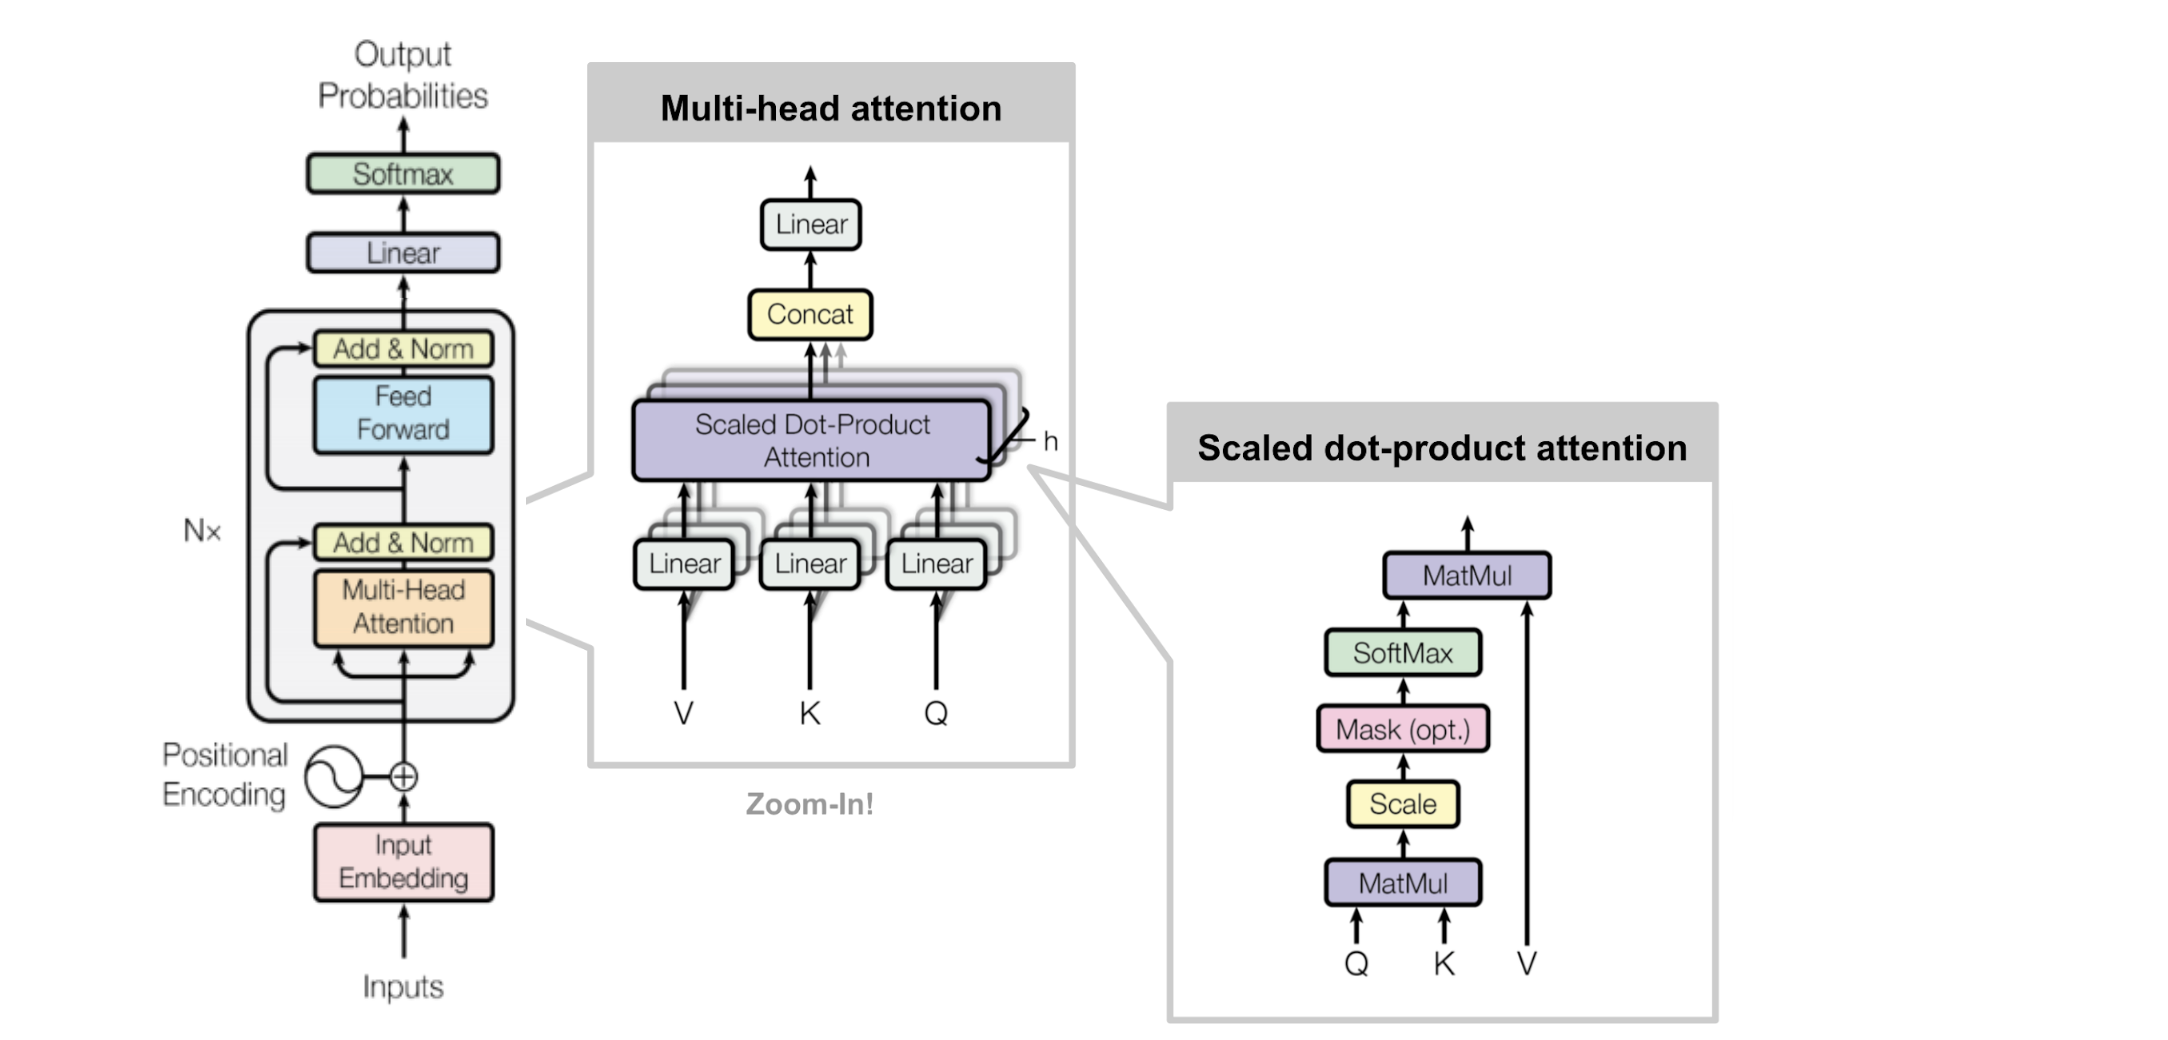

## 2.1 Dot product attention
Now you will implement dot product attention which takes in a query, key, value, and a mask. It returns the output.

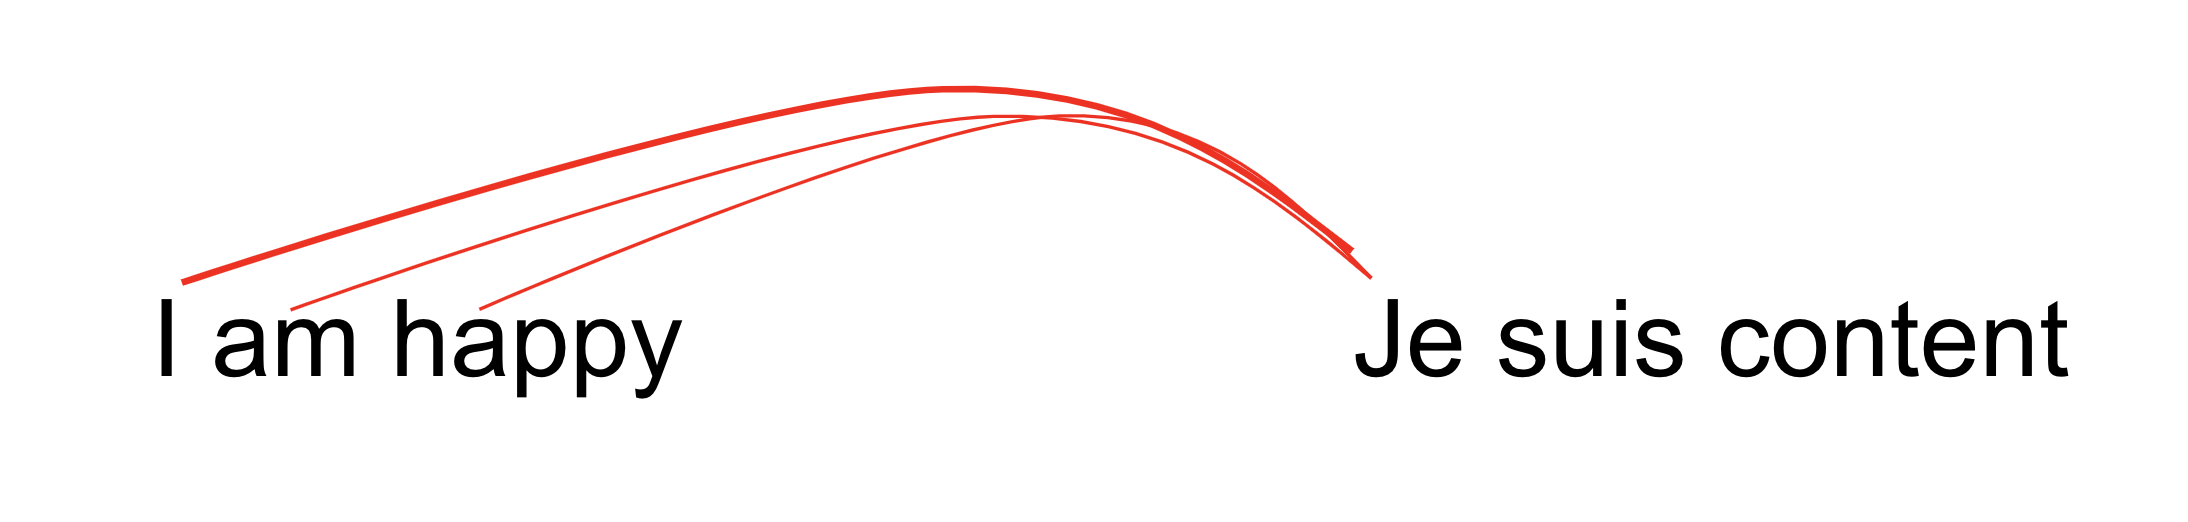

Here are some helper functions that will help you create tensors and display useful information:

create_tensor creates a jax numpy array from a list of lists.
display_tensor prints out the shape and the actual tensor.

In [15]:
def create_tensor(t):
    """Create a tensor from a list of lists."""
    return jnp.array(t)

def display_tensor(t, name):
    """Display shape and tensor"""
    print(f"{name} shape: {t.shape}")
    print(f"{t}")

Before implementing it yourself, you can play around with a toy example of dot product attention without the softmax operation. Technically it would not be dot product attention without the softmax but this is done to avoid giving away too much of the answer and the idea is to display these tensors to give you a sense of how they look like.

The formula for attention is this one:

$$ \text { Attention }(Q, K, V)=\operatorname{softmax}\left(\frac{Q K^{T}}{\sqrt{d_{k}}}+{M}\right) V\tag{1}\ $$
$d_{k}$ stands for the dimension of queries and keys.

The query, key, value and mask vectors are provided for this example.

Notice that the masking is done using very negative values that will yield a similar effect to using $-\infty $.

In [16]:
q = create_tensor([[1, 0, 0], [0, 1, 0]])
display_tensor(q, 'query')
k = create_tensor([[1, 2, 3], [4, 5, 6]])
display_tensor(k, 'key')
v = create_tensor([[0, 1, 0], [1, 0, 1]])
display_tensor(v, 'value')
m = create_tensor([[0, 0], [-1e9, 0]])
display_tensor(m, 'mask')

query shape: (2, 3)
[[1 0 0]
 [0 1 0]]
key shape: (2, 3)
[[1 2 3]
 [4 5 6]]
value shape: (2, 3)
[[0 1 0]
 [1 0 1]]
mask shape: (2, 2)
[[ 0.e+00  0.e+00]
 [-1.e+09  0.e+00]]


In [17]:
q_dot_k = q @ k.T/jnp.sqrt(3)
display_tensor(q_dot_k, "query dot key")

query dot key shape: (2, 2)
[[0.57735026 2.309401  ]
 [1.1547005  2.8867512 ]]


In order to use the previous dummy tensors to test some of the graded functions, a batch dimension should be added to them so they mimic the shape of real-life examples. The mask is also replaced by a version of it that resembles the one that is used by trax:

In [18]:
q_with_batch = q[None, :]
display_tensor(q_with_batch, 'query with batch dim')

k_with_batch = k[None, :]
display_tensor(k_with_batch, 'query with batch dim')

v_with_batch = v[None, :]
display_tensor(v_with_batch, 'query with batch dim')

m_bool = create_tensor([[True, True], [False, True]])
display_tensor(m_bool, 'boolean mask')

query with batch dim shape: (1, 2, 3)
[[[1 0 0]
  [0 1 0]]]
query with batch dim shape: (1, 2, 3)
[[[1 2 3]
  [4 5 6]]]
query with batch dim shape: (1, 2, 3)
[[[0 1 0]
  [1 0 1]]]
boolean mask shape: (2, 2)
[[ True  True]
 [False  True]]


# Exercise 01
Instructions: Implement the dot product attention. Concretely, implement the following equation

$$ \text { Attention }(Q, K, V)=\operatorname{softmax}\left(\frac{Q K^{T}}{\sqrt{d_{k}}}+{M}\right) V\tag{1}\ $$
$Q$ - query, $K$ - key, $V$ - values, $M$ - mask, ${d_k}$ - depth/dimension of the queries and keys (used for scaling down)

You can implement this formula either by trax numpy (trax.math.numpy) or regular numpy but it is recommended to use jnp.

Something to take into consideration is that within trax, the masks are tensors of True/False values not 0's and $-\infty$ as in the previous example. Within the graded function don't think of applying the mask by summing up matrices, instead use jnp.where() and treat the mask as a tensor of boolean values with False for values that need to be masked and True for the ones that don't.

Also take into account that the real tensors are far more complex than the toy ones you just played with. Because of this **avoid using shortened operations such as @ for dot product or .T for transposing. Use jnp.matmul() and jnp.swapaxes() instead.**

This is the self-attention block for the transformer decoder. Good luck!

In [19]:
def DotProductAttention(query, key, value, mask):
    """
    Dot product self-attention.

    Inputs:
      query (jax.interpreters.xla.DeviceArray): array of query representations with shape (L_q by d)
        key (jax.interpreters.xla.DeviceArray): array of key representations with shape (L_k by d)
        value (jax.interpreters.xla.DeviceArray): array of value representations with shape (L_k by d) where L_v = L_k
        mask (jax.interpreters.xla.DeviceArray): attention-mask, gates attention with shape (L_q by L_k)

    Outputs:
        jax.interpreters.xla.DeviceArray: Self-attention array for q, k, v arrays. (L_q by L_k)
     
     """

    assert query.shape[-1] == key.shape[-1] == value.shape[-1] # Check the embedding size

    # Save depth/dimension of the query embedding for scaling down the dot product
    depth = key.shape[-1]

    # Calculate scaled query key dot product according to formula above
    dots = jnp.matmul(query, jnp.swapaxes(key, -1, -2)) / jnp.sqrt(depth)

    # Apply the mask
    if mask is not None:
      dots = jnp.where(mask, dots, jnp.full_like(dots, -1e9))

    # Softmax formula implementation
    # Use trax.fastmath.logsumexp of dots to avoid underflow by division by large numbers
    # Hint: Last axis should be used and keepdims should be True
    # Note: softmax = e^(dots - logsumexp(dots)) = E^dots / sumexp(dots)

    logsumexp = trax.fastmath.logsumexp(dots, axis = -1, keepdims = True)

    # Take exponential of dots minus logsumexp to get softmax
    # Use jnp.exp()
    dots = jnp.exp(dots - logsumexp)

    # Multiply dots by value to get self-attention
    # Use jnp.matmul()
    attention = jnp.matmul(dots, value)

    return attention

In [20]:
DotProductAttention(q_with_batch, k_with_batch, v_with_batch, m_bool)

DeviceArray([[[0.8496746 , 0.15032545, 0.8496746 ],
              [1.        , 0.        , 1.        ]]], dtype=float32)

## 2.2 Causal Attention
Now you are going to implement causal attention: multi-headed attention with a mask to attend only to words that occurred before.

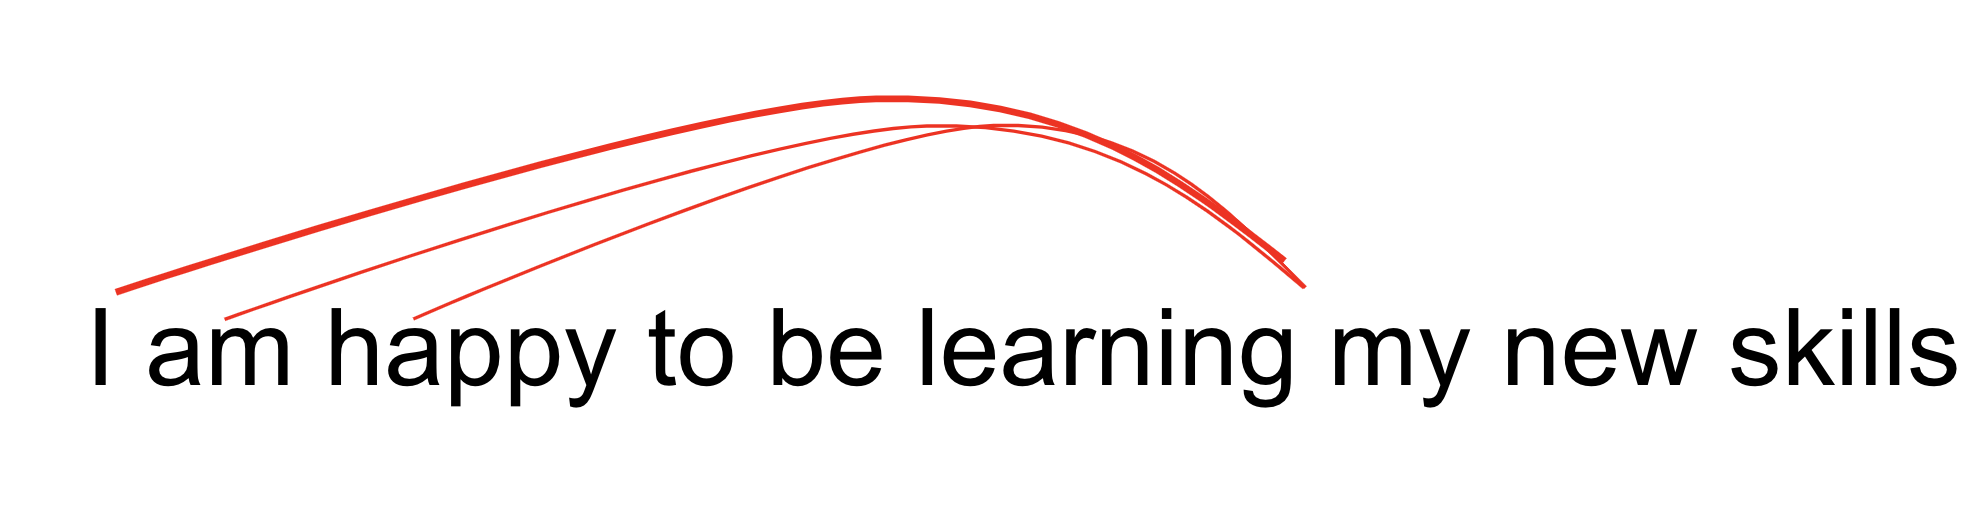

In the image above, a word can see everything that is before it, but not what is after it. To implement causal attention, you will have to transform vectors and do many reshapes. You will need to implement the functions below.

# Exercise 02
Implement the following functions that will be needed for Causal Attention:

* Compute_attention_heads : Gets an input $x$ of dimension (batch_size, seqlen, n_heads $\times$ d_head) and splits the last (depth) dimension and stacks it to the zeroth dimension to allow matrix multiplication (batch_size $\times$ n_heads, seqlen, d_head).
* dot_product_self_attention : Creates a mask matrix with False values above the diagonal and True values below and calls DotProductAttention which implements dot product self attention.
compute_attention_output : Undoes compute_attention_heads by splitting first (vertical) dimension and stacking in the last (depth) dimension (batch_size, seqlen, n_heads $\times$ d_head). These operations concatenate (stack/merge) the heads.

In [21]:
tensor2d = create_tensor(q)
display_tensor(tensor2d, 'query matrix (2D tensor)')

tensor4d2b = create_tensor([[q, q], [q, q]])
display_tensor(tensor4d2b, 'batch of two (multi-head) collections of query matrices (4D tensor)')

tensor3dc = create_tensor([jnp.concatenate([q, q], axis = -1)])
display_tensor(tensor3dc, 'one batch of concatenated heads of query matrices (3d tensor)')

tensor3dc3b = create_tensor([jnp.concatenate([q, q], axis = -1), jnp.concatenate([q, q], axis = -1), jnp.concatenate([q, q], axis = -1)])
display_tensor(tensor3dc3b, 'three batches of concatenated heads of query matrices (3d tensor)')

query matrix (2D tensor) shape: (2, 3)
[[1 0 0]
 [0 1 0]]
batch of two (multi-head) collections of query matrices (4D tensor) shape: (2, 2, 2, 3)
[[[[1 0 0]
   [0 1 0]]

  [[1 0 0]
   [0 1 0]]]


 [[[1 0 0]
   [0 1 0]]

  [[1 0 0]
   [0 1 0]]]]
one batch of concatenated heads of query matrices (3d tensor) shape: (1, 2, 6)
[[[1 0 0 1 0 0]
  [0 1 0 0 1 0]]]
three batches of concatenated heads of query matrices (3d tensor) shape: (3, 2, 6)
[[[1 0 0 1 0 0]
  [0 1 0 0 1 0]]

 [[1 0 0 1 0 0]
  [0 1 0 0 1 0]]

 [[1 0 0 1 0 0]
  [0 1 0 0 1 0]]]


It is important to know that the following 3 functions would normally be defined within the CausalAttention function further below.

However this makes these functions harder to test. Because of this, these functions are shown individually using a closure (when necessary) that simulates them being inside of the CausalAttention function. This is done because they rely on some variables that can be accessed from within CausalAttention.

Support Functions
compute_attention_heads : Gets an input $x$ of dimension (batch_size, seqlen, n_heads $\times$ d_head) and splits the last (depth) dimension and stacks it to the zeroth dimension to allow matrix multiplication (batch_size $\times$ n_heads, seqlen, d_head).

For the closures you only have to fill the inner function.

In [22]:
def compute_attention_heads_closure(n_heads, d_head):

    """
    Function that simulates environment inside CausalAttention function.
    Args:
        d_head (int):  dimensionality of heads.
        n_heads (int): number of attention heads.
    Returns:
        function: compute_attention_heads function
    """

    def compute_attention_heads(x):
        """ Compute the attention heads. (Matrices)
        Args:
            x (jax.interpreters.xla.DeviceArray): tensor with shape (batch_size, seqlen, n_heads X d_head).
        Returns:
            jax.interpreters.xla.DeviceArray: reshaped tensor with shape (batch_size X n_heads, seqlen, d_head).
        """

        batch_size = x.shape[0]
        seqlen = x.shape[1]

        # Reshape x using jnp.reshape()
        # batch_size, seqlen, n_heads*d_head -> batch_size, seqlen, n_heads, d_head
        x = jnp.reshape(x, (batch_size, seqlen, n_heads, d_head))

        # Transpose x using jnp.transpose()
        # batch_size, seqlen, n_heads, d_head -> batch_size, n_heads, seqlen, d_head
        # Note that the values within the tuple are the indexes of the dimensions of x and you must rearrange them

        x = jnp.transpose(x, (0, 2, 1, 3))

        # Reshape x using jnp.reshape()
        # batch_size, n_heads, seqlen, d_head -> batch_size*n_heads, seqlen, d_head

        x = jnp.reshape(x, (-1, seqlen, d_head))

        return x

    
    return compute_attention_heads



In [23]:
display_tensor(tensor3dc3b, "input tensor")
result_cah = compute_attention_heads_closure(2,3)(tensor3dc3b)
display_tensor(result_cah, "output tensor")

input tensor shape: (3, 2, 6)
[[[1 0 0 1 0 0]
  [0 1 0 0 1 0]]

 [[1 0 0 1 0 0]
  [0 1 0 0 1 0]]

 [[1 0 0 1 0 0]
  [0 1 0 0 1 0]]]
output tensor shape: (6, 2, 3)
[[[1 0 0]
  [0 1 0]]

 [[1 0 0]
  [0 1 0]]

 [[1 0 0]
  [0 1 0]]

 [[1 0 0]
  [0 1 0]]

 [[1 0 0]
  [0 1 0]]

 [[1 0 0]
  [0 1 0]]]


dot_product_self_attention : Creates a mask matrix with False values above the diagonal and True values below and calls DotProductAttention which implements dot product self attention.

In [24]:
def dot_product_self_attention(q, k, v):
    """ Masked dot product self attention.
    Args:
        q (jax.interpreters.xla.DeviceArray): queries.
        k (jax.interpreters.xla.DeviceArray): keys.
        v (jax.interpreters.xla.DeviceArray): values.
    Returns:
        jax.interpreters.xla.DeviceArray: masked dot product self attention tensor.
    """

    # Hint: mask size should be equal to L_q. Remember that q has shape (batch_size, L_q, d)
    # NOTE: there is a revision underway with the autograder to tolerate better indexing. 
    # Until then, please index q.shape using negative values (this is equivalent to counting from right to left)

    mask_size = q.shape[-2]

    # Creates a matrix with ones below the diagonal and 0s above. It should have shape (1, mask_size, mask_size)
    # Notice that 1's and 0's get casted to True/False by setting dtype to jnp.bool_
    # Use jnp.tril() - Lower triangle of an array and jnp.ones()

    mask = jnp.tril(jnp.ones((1, mask_size, mask_size), dtype = jnp.bool_), k = 0) # K = 0 is main diagonal, k = +/-1 is diagonal above/below and so on

    return DotProductAttention(q, k, v, mask)

In [25]:
dot_product_self_attention(q_with_batch, k_with_batch, v_with_batch)

DeviceArray([[[0.        , 1.        , 0.        ],
              [0.8496746 , 0.15032548, 0.8496746 ]]], dtype=float32)

compute_attention_output : Undoes compute_attention_heads by splitting first (vertical) dimension and stacking in the last (depth) dimension (batch_size, seqlen, n_heads $\times$ d_head). These operations concatenate (stack/merge) the heads.

In [26]:
def compute_attention_output_closure(n_heads, d_head):
    """ Function that simulates environment inside CausalAttention function.
    Args:
        d_head (int):  dimensionality of heads.
        n_heads (int): number of attention heads.
    Returns:
        function: compute_attention_output function
    """

    def compute_attention_output(x):
        """ Compute the attention output.
        Args:
            x (jax.interpreters.xla.DeviceArray): tensor with shape (batch_size X n_heads, seqlen, d_head).
        Returns:
            jax.interpreters.xla.DeviceArray: reshaped tensor with shape (batch_size, seqlen, n_heads X d_head).
        """

        # Length of the sequence
        # Should be size of x's first dimension without counting the batch dim

        seqlen = x.shape[1]

        # Reshape x using jnp.reshape() to shape (batch_size, n_heads, seqlen, d_head)

        x = jnp.reshape(x, (-1, n_heads, seqlen, d_head))

        # Transpose x using jnp.transpose() to shape (batch_size, seqlen, n_heads, d_head)

        x = jnp.transpose(x, (0, 2, 1, 3))

        # Reshape to allow to concatenate the heads

        x = jnp.reshape(x, (-1, seqlen, n_heads * d_head))

        return x

    return compute_attention_output

In [27]:
display_tensor(result_cah, "input tensor")
result_cao = compute_attention_output_closure(2,3)(result_cah)
display_tensor(result_cao, "output tensor")

input tensor shape: (6, 2, 3)
[[[1 0 0]
  [0 1 0]]

 [[1 0 0]
  [0 1 0]]

 [[1 0 0]
  [0 1 0]]

 [[1 0 0]
  [0 1 0]]

 [[1 0 0]
  [0 1 0]]

 [[1 0 0]
  [0 1 0]]]
output tensor shape: (3, 2, 6)
[[[1 0 0 1 0 0]
  [0 1 0 0 1 0]]

 [[1 0 0 1 0 0]
  [0 1 0 0 1 0]]

 [[1 0 0 1 0 0]
  [0 1 0 0 1 0]]]


# Causal Attention Function
Now it is time for you to put everything together within the CausalAttention or Masked multi-head attention function:

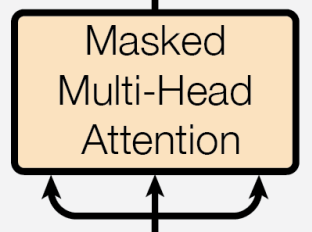

Instructions: Implement the causal attention. Your model returns the causal attention through a $tl.Serial$ with the following:

* [tl.Branch](https://trax-ml.readthedocs.io/en/latest/trax.layers.html#trax.layers.combinators.Branch) : consisting of 3 [tl.Dense(d_feature), ComputeAttentionHeads] to account for the queries, keys, and values.
* [tl.Fn](https://trax-ml.readthedocs.io/en/latest/trax.layers.html#trax.layers.base.Fn): Takes in dot_product_self_attention function and uses it to compute the dot product using $Q$, $K$, $V$.
* [tl.Fn](https://trax-ml.readthedocs.io/en/latest/trax.layers.html#trax.layers.base.Fn): Takes in restack_attention_heads to allow for parallel computing.
* [tl.Dense](https://trax-ml.readthedocs.io/en/latest/trax.layers.html#trax.layers.core.Dense): Final Dense layer, with dimension d_feature.
Remember that in order for trax to properly handle the functions you just defined, they need to be added as layers using the tl.Fn() function.

In [35]:
def CausalAttention(d_feature,
                    n_heads,
                    compute_attention_heads_closure = compute_attention_heads_closure,
                    dot_product_self_attention = dot_product_self_attention,
                    compute_attention_output_closure = compute_attention_output_closure,
                    mode = "train"):
  
  """Transformer-style multi-headed causal attention.

    Args:
        d_feature (int):  dimensionality of feature embedding.
        n_heads (int): number of attention heads.
        compute_attention_heads_closure (function): Closure around compute_attention heads.
        dot_product_self_attention (function): dot_product_self_attention function. 
        compute_attention_output_closure (function): Closure around compute_attention_output. 
        mode (str): 'train' or 'eval'.

    Returns:
        trax.layers.combinators.Serial: Multi-headed self-attention model.
    """
    
  assert d_feature % n_heads == 0
  d_head = d_feature // n_heads

  # The second argument to tl.Fn() is an uncalled function (without the parentheses)
  # Since you are dealing with closures you need to call the outer 
  # function with the correct parameters to get the actual uncalled function.

  ComputeAttentionHeads = tl.Fn("AttnHeads", compute_attention_heads_closure(n_heads, d_head), n_out = 1)

                              # creates three towers for one input, takes activations and creates queries keys and values
  model = tl.Serial(tl.Branch([tl.Dense(d_feature), ComputeAttentionHeads], #Keys
                              [tl.Dense(d_feature), ComputeAttentionHeads], #Queries
                              [tl.Dense(d_feature), ComputeAttentionHeads]),#Values
                    tl.Fn("DotProductAttn", dot_product_self_attention, n_out = 1),
                    # takes QKV
                    # HINT: The second argument to tl.Fn() is an uncalled function
                    # Since you are dealing with closures you might need to call the outer 
                    # function with the correct parameters to get the actual uncalled function.
                    tl.Fn("AttnOutput", compute_attention_output_closure(n_heads, d_head), n_out = 1),
                    tl.Dense(d_feature)
                    )
  
  return model

In [36]:
print(CausalAttention(d_feature = 512, n_heads = 8))

Serial[
  Branch_out3[
    [Dense_512, AttnHeads]
    [Dense_512, AttnHeads]
    [Dense_512, AttnHeads]
  ]
  DotProductAttn_in3
  AttnOutput
  Dense_512
]


# 2.3 Transformer decoder block
Now that you have implemented the causal part of the transformer, you will implement the transformer decoder block. Concretely you will be implementing this image now.

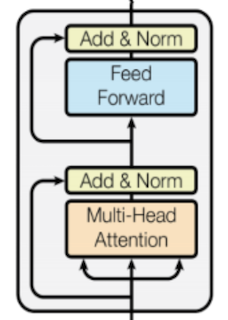

To implement this function, you will have to call the CausalAttention or Masked multi-head attention function you implemented above. You will have to add a feedforward which consists of:

* [tl.LayerNorm](https://trax-ml.readthedocs.io/en/latest/trax.layers.html#trax.layers.normalization.LayerNorm) : used to layer normalize
* [tl.Dense](https://trax-ml.readthedocs.io/en/latest/trax.layers.html#trax.layers.core.Dense) : the dense layer
* [ff_activation](https://trax-ml.readthedocs.io/en/latest/trax.layers.html#trax.layers.activation_fns.Relu) : feed forward activation (we use ReLu) here.
* [tl.Dropout](https://trax-ml.readthedocs.io/en/latest/trax.layers.html#trax.layers.core.Dropout) : dropout layer
* [tl.Dense](https://trax-ml.readthedocs.io/en/latest/trax.layers.html#trax.layers.core.Dense) : dense layer
* [tl.Dropout](https://trax-ml.readthedocs.io/en/latest/trax.layers.html#trax.layers.core.Dropout) : dropout layer

Finally once you implement the feedforward, you can go ahead and implement the entire block using:

* [tl.Residual](https://trax-ml.readthedocs.io/en/latest/trax.layers.html#trax.layers.combinators.Residual) : takes in the tl.LayerNorm(), causal attention block, tl.dropout.

* [tl.Residual](https://trax-ml.readthedocs.io/en/latest/trax.layers.html#trax.layers.combinators.Residual) : takes in the feedforward block you will implement.

In [37]:
def DecoderBlock(d_model, d_ff, n_heads, dropout, mode, ff_activation):
    """
    Returns a list of layers that implements a Transformer decoder block.

    The input is an activation tensor.

    Args:
        d_model (int):  depth of embedding.
        d_ff (int): depth of feed-forward layer.
        n_heads (int): number of attention heads.
        dropout (float): dropout rate (how much to drop out).
        mode (str): 'train' or 'eval'.
        ff_activation (function): the non-linearity in feed-forward layer.

    Returns:
        list: list of trax.layers.combinators.Serial that maps an activation tensor to an activation tensor.   
    """

    # Create masked multi-head attention block using CausalAttention function
    causal_attention = CausalAttention(d_model, n_heads = n_heads, mode = mode)

    # Create feed-forward block (list) with two dense layers with dropout and input normalized

    feed_forward = [
                    #Normalize layer input
                    tl.LayerNorm(),
                    tl.Dense(d_ff),
                    ff_activation(), # Relu or whatever
                    tl.Dropout(rate = dropout, mode = mode), # Don't use it in eval mode
                    tl.Dense(d_model),
                    tl.Dropout(rate = dropout, mode = mode)]

    block = [tl.Residual(tl.LayerNorm(),
                         causal_attention,
                         tl.Dropout(rate = dropout, mode = mode)
                         ),
             tl.Residual(feed_forward)
            ]

    return block

In [39]:
print(DecoderBlock(d_model = 512, d_ff = 2048, n_heads = 8, dropout =0.1, mode = "train", ff_activation = tl.Relu))

[Serial[
  Branch_out2[
    None
    Serial[
      LayerNorm
      Serial[
        Branch_out3[
          [Dense_512, AttnHeads]
          [Dense_512, AttnHeads]
          [Dense_512, AttnHeads]
        ]
        DotProductAttn_in3
        AttnOutput
        Dense_512
      ]
      Dropout
    ]
  ]
  Add_in2
], Serial[
  Branch_out2[
    None
    Serial[
      LayerNorm
      Dense_2048
      Serial[
        Relu
      ]
      Dropout
      Dense_512
      Dropout
    ]
  ]
  Add_in2
]]


# 2.4 Transformer Language Model
You will now bring it all together. In this part you will use all the subcomponents you previously built to make the final model. Concretely, here is the image you will be implementing.

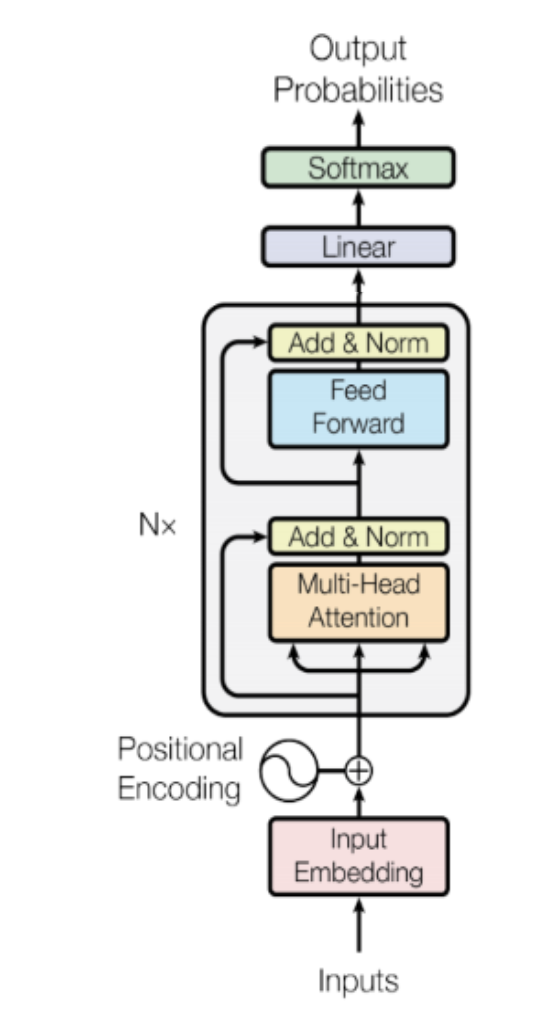

**Instructions:** Previously you coded the decoder block. Now you will code the transformer language model. Here is what you will need.

* positional_enconder - a list containing the following layers:

  * tl.Embedding
  * tl.Dropout
  * tl.PositionalEncoding
* A list of n_layers decoder blocks.

* [tl.Serial](https://trax-ml.readthedocs.io/en/latest/trax.layers.html#trax.layers.combinators.Serial): takes in the following layers or lists of layers:
  * [tl.ShiftRight](https://trax-ml.readthedocs.io/en/latest/trax.layers.html#trax.layers.attention.ShiftRight): : shift the tensor to the right by padding on axis 1.
  * positional_encoder : encodes the text positions.
  * decoder_blocks : the ones you created.
  * [tl.LayerNorm](https://trax-ml.readthedocs.io/en/latest/trax.layers.html#trax.layers.normalization.LayerNorm) : a layer norm.
  * [tl.Dense](https://trax-ml.readthedocs.io/en/latest/trax.layers.html#trax.layers.core.Dense) : takes in the vocab_size.
  * [tl.LogSoftmax](https://trax-ml.readthedocs.io/en/latest/trax.layers.html#trax.layers.core.LogSoftmax) : to predict.

In [45]:
def TransformerLM(vocab_size = 33000,
                  d_model = 512,
                  d_ff = 2048,
                  n_layers = 6,
                  n_heads = 8,
                  max_len = 4096,
                  dropout = 0.1,
                  mode = "train",
                  ff_activation = tl.Relu):
    """
    Returns a Transformer language model.

    The input to the model is a tensor of tokens. (This model uses only the
    decoder part of the overall Transformer.)

    Args:
        vocab_size (int): vocab size.
        d_model (int):  depth of embedding.
        d_ff (int): depth of feed-forward layer.
        n_layers (int): number of decoder layers.
        n_heads (int): number of attention heads.
        dropout (float): dropout rate (how much to drop out).
        max_len (int): maximum symbol length for positional encoding.
        mode (str): 'train', 'eval' or 'predict', predict mode is for fast inference.
        ff_activation (function): the non-linearity in feed-forward layer.

    Returns:
        trax.layers.combinators.Serial: A Transformer language model as a layer that maps from a tensor of tokens
        to activations over a vocab set.

    """

    # Embedding inputs and positional encoder
    positional_encoder = [
                        tl.Embedding(vocab_size = vocab_size, d_feature = d_model),
                        tl.Dropout(rate = dropout, mode = mode),
                        # Add positional encoding layer with maximum input length and mode specified
                        tl.PositionalEncoding(max_len = max_len, mode = mode)
                        ]
    
    # Create stack (list) of decoder blocks with n_layers with necessary parameters
    decoder_blocks = [DecoderBlock(d_model, d_ff, n_heads, dropout, mode, ff_activation) for _ in range(n_layers)]

    # Create the complete model as written in the figure
    model = tl.Serial(# Use teacher forcing (feed output of previous step to current step)
                      tl.ShiftRight(mode = mode),
                      positional_encoder,
                      decoder_blocks,
                      tl.LayerNorm(),
                      # Add dense layer of vocab_size (since need to select a word to translate to)
                      # (a.k.a., logits layer. Note: activation already set by ff_activation)
                      tl.Dense(vocab_size),
                      tl.LogSoftmax()
                      )
    
    return model

In [46]:
print(TransformerLM(n_layers = 1))

Serial[
  Serial[
    ShiftRight(1)
  ]
  Embedding_33000_512
  Dropout
  PositionalEncoding
  Serial[
    Branch_out2[
      None
      Serial[
        LayerNorm
        Serial[
          Branch_out3[
            [Dense_512, AttnHeads]
            [Dense_512, AttnHeads]
            [Dense_512, AttnHeads]
          ]
          DotProductAttn_in3
          AttnOutput
          Dense_512
        ]
        Dropout
      ]
    ]
    Add_in2
  ]
  Serial[
    Branch_out2[
      None
      Serial[
        LayerNorm
        Dense_2048
        Serial[
          Relu
        ]
        Dropout
        Dense_512
        Dropout
      ]
    ]
    Add_in2
  ]
  LayerNorm
  Dense_33000
  LogSoftmax
]


# Part 3: Training
Now you are going to train your model. As usual, you have to define the cost function, the optimizer, and decide whether you will be training it on a gpu or cpu. In this case, you will train your model on a cpu for a few steps and we will load in a pre-trained model that you can use to predict with your own words.

## 3.1 Training the model
You will now write a function that takes in your model and trains it. To train your model you have to decide how many times you want to iterate over the entire data set. Each iteration is defined as an epoch. For each epoch, you have to go over all the data, using your training iterator.

**Instructions:** Implement the train_model program below to train the neural network above. Here is a list of things you should do:

* Create the train task by calling trax.supervised.training.TrainTask and pass in the following:
  * labeled_data = train_gen
  * loss_fn = tl.CrossEntropyLoss()
  * optimizer = trax.optimizers.Adam(0.01)
  * lr_schedule = lr_schedule
* Create the eval task by calling trax.supervised.training.EvalTask and pass in the following:
  * labeled_data = eval_gen
  * metrics = tl.CrossEntropyLoss() and tl.Accuracy()
* Create the training loop by calling trax.supervised.Training.Loop and pass in the following:
  * TransformerLM
  * train_task
  * eval_task = [eval_task]
  * output_dir = output_dir

The training loop that this function returns can be runned using the run() method by passing in the desired number of steps.

In [54]:
def training_loop(TransformerLM, train_gen, eval_gen, output_dir = "~/model"):
    """
    Input:
        TransformerLM (trax.layers.combinators.Serial): The model you are building.
        train_gen (generator): Training stream of data.
        eval_gen (generator): Evaluation stream of data.
        output_dir (str): folder to save your file.
        
    Returns:
        trax.supervised.training.Loop: Training loop.

    """

    output_dir = os.path.expanduser(output_dir) #trainer is an object
    lr_schedule = trax.lr.warmup_and_rsqrt_decay(n_warmup_steps = 1000, max_value = 0.01)

    train_task = training.TrainTask(labeled_data = train_gen,
                                    loss_layer = tl.CrossEntropyLoss(),
                                    optimizer = trax.optimizers.Adam(0.01),
                                    lr_schedule = lr_schedule,
                                    n_steps_per_checkpoint = 10
                                    )
    
    eval_task = training.EvalTask(labeled_data = eval_gen,
                                  metrics = [tl.CrossEntropyLoss(), tl.Accuracy()]
                                  )
    
    loop = training.Loop(TransformerLM(d_model = 4,
                                       d_ff = 16,
                                       n_layers = 1,
                                       n_heads = 4,
                                       mode = "train"),
                         train_task,
                         eval_tasks = [eval_task],
                         output_dir = output_dir
                        )
    
    return loop

The model will be trained for only 10 steps.

Even with this constraint the model with the original default arguments took a very long time to finish. Because of this some parameters are changed when defining the model that is fed into the training loop in the function above.

In [55]:
!rm -f ~/model/model.pkl.gz
loop = training_loop(TransformerLM, train_batch_stream, eval_batch_stream)
loop.run(10)


Step      1: Total number of trainable weights: 313636
Step      1: Ran 1 train steps in 3.57 secs
Step      1: train CrossEntropyLoss |  10.40503216
Step      1: eval  CrossEntropyLoss |  10.40356159
Step      1: eval          Accuracy |  0.00000000

Step     10: Ran 9 train steps in 4.59 secs
Step     10: train CrossEntropyLoss |  10.40497017
Step     10: eval  CrossEntropyLoss |  10.40371037
Step     10: eval          Accuracy |  0.00000000
